# FINESST Plots

1. Figure 1 with just the longwave panels.  

2. AIRS Spectral OLR trends with temperature trends in the sidebar.

## 1. Figure 1 with just the longwave panels.  

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [5]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [6]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [7]:
giss_tsel = giss1.sel(time=slice('2001-01','2020-12'))['air']

In [8]:
giss1.close()

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [86]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [87]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [88]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [89]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [124]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for ii,(i,_month) in enumerate(subset_data.groupby('time.month')): # fix to handle not all months
        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        # ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Calculate trends and statistical significance

#### CERES OLR

In [91]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [92]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif2(ceres_olr_subset)

#### Temperature from GISStemp

In [14]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [15]:
gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif2(gisstemp_subset)

### Plot summary data

#### Wrap data for better visualization

In [16]:
gisstemp_trends_wrapped = xr.concat([gisstemp_trends,gisstemp_trends[0].assign_coords({'month':13})],dim='month')
gisstemp_statsig_wrapped = xr.concat([gisstemp_statsig,gisstemp_statsig[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

Text(0.5, 0.97, 'Observed Trends')

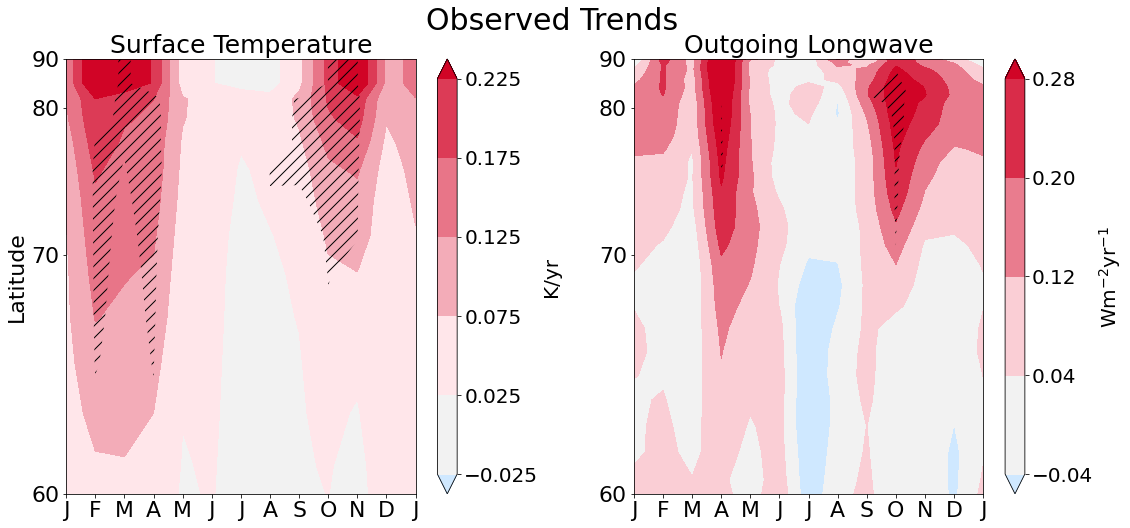

In [22]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=5, as_cmap=True)

fig1,axs = plt.subplots(nrows=1,ncols=2,figsize=(18,8))
fig1.subplots_adjust(wspace=0.3,hspace=0.2)

axes = axs.flat

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)

axes[0].set_ylabel('Latitude',fontsize=22)

lat_weighted0 = np.sin(np.pi/180*gisstemp_trends['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(gisstemp_trends_wrapped['month'],lat_weighted0,gisstemp_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im0.cmap.set_under((0.81,0.91,1.00))
stip = axes[0].contourf(gisstemp_statsig_wrapped['month'],lat_weighted0,gisstemp_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Surface Temperature',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='K/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*olr_trends['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(olr_trends_wrapped['month'],lat_weighted1,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im1.cmap.set_under((0.81,0.91,1.00))
stip = axes[1].contourf(olr_statsig_wrapped['month'],lat_weighted1,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Outgoing Longwave',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('Observed Trends',fontsize=30,y=0.97)

In [23]:
to_png(fig1,'observedtLWrends_2panel')

## 2. AIRS Spectral OLR trends with temperature trends in the sidebar.

#### Load pre-calculated AIRS trends (lon. averaged)

In [5]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'

all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))
all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))    

In [6]:
all_data_spec_olr_wgtd = add_weights(all_data_spec_olr['TREND'])
all_data_spec_olr_clr_wgtd = add_weights(all_data_spec_olr_clr['TREND'])

In [10]:
all_data_spec_olr_statsig_wgtd = add_weights(all_data_spec_olr['STATSIG'])
all_data_spec_olr_clr_statsig_wgtd = add_weights(all_data_spec_olr_clr['STATSIG'])

In [38]:
all_data_spec_olr_wgtd['lat']<70

<xarray.DataArray 'lat' (lat: 16)>
array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False])
Coordinates:
  * lat          (lat) float32 59.0 61.0 63.0 65.0 67.0 ... 83.0 85.0 87.0 89.0
    cell_weight  (lat) float32 0.11830921 0.11136543 ... 0.01202205 0.0040089805

In [39]:
all_data_spec_olr.close()
all_data_spec_olr_clr.close()

olr_trend_spatavg = masked_average(all_data_spec_olr_wgtd,dim=['lat'],
                                   weights=all_data_spec_olr_wgtd['cell_weight'],mask=all_data_spec_olr_wgtd['lat']<70)
olr_clr_trend_spatavg = masked_average(all_data_spec_olr_clr_wgtd,dim=['lat'],
                                       weights=all_data_spec_olr_clr_wgtd['cell_weight'],mask=all_data_spec_olr_clr_wgtd['lat']<70)

olr_statsig_spatavg = masked_average(all_data_spec_olr_statsig_wgtd,dim=['lat'],
                                     weights=all_data_spec_olr_statsig_wgtd['cell_weight'],mask=all_data_spec_olr_statsig_wgtd['lat']<70)
olr_clr_statsig_spatavg = masked_average(all_data_spec_olr_clr_statsig_wgtd,dim=['lat'],
                                         weights=all_data_spec_olr_clr_statsig_wgtd['cell_weight'],mask=all_data_spec_olr_clr_statsig_wgtd['lat']<70)

### Nice plot for OLR

In [103]:
gisstemp_AIRSsubset = giss_tsel.sel(lat=slice(None,59),time=slice('2003-01-01','2018-12-31'))

gisstemp_AIRStrends,gisstemp_AIRSstatsig,gisstemp_AIRSnotnull = compute_trends_n_signif2(gisstemp_AIRSsubset)
gisstemp_AIRStrends_wgtd = add_weights(gisstemp_AIRStrends)
gisstemp_AIRStrends_spatavg = masked_average(gisstemp_AIRStrends_wgtd,weights=gisstemp_AIRStrends_wgtd['cell_weight'],dim=['lat','lon'])

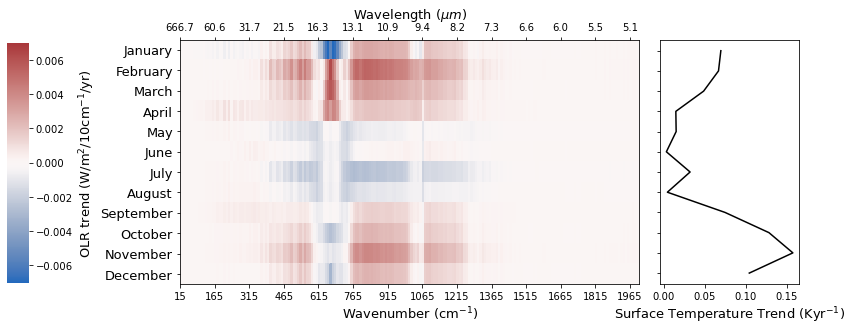

In [160]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

nuthin = 199*[None]

# Only take every 15th wnum label (there must be a better way)
new_labels = [olr_trend_spatavg.wnum[i].values if i%15 == 0 else b for  i,b in enumerate(nuthin)]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

fig1 = plt.figure(constrained_layout=False,figsize=(20,4.5))
gs1 = fig1.add_gridspec(nrows=3, ncols=4, left=0.05, right=0.48, wspace=0.15,hspace=0.4)
f1_ax1 = fig1.add_subplot(gs1[:, :3])
f1_ax2 = fig1.add_subplot(gs1[:, 3:])

# Plot the average OLR
# olr_trend_spatavg[:,:,0].groupby('time.month').mean('time').mean('month').plot(ax=f1_ax1,xlim=[15,1995])
# f1_ax1.set_title('AIRS OLR 2002-09 to 2019-06')# (Wm$^{-2}$)')
# fig1.suptitle('AIRS OLR 2002-09 to 2019-06 (Wm$^{-2}$)')

cbar_axh2 = fig1.add_axes([-0.07, 0.13, 0.015, 0.74])
# cbar_axh2 = fig1.add_axes([0.5, 0.15, 0.02, 0.72])

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',
            xticklabels=new_labels,yticklabels=mon_dict.values(),
           ax=f1_ax1,cbar_ax=cbar_axh2,vmin=-0.007,vmax=0.007)

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)', fontsize=13)


f1_ax2.plot(gisstemp_AIRStrends_spatavg,gisstemp_AIRStrends_spatavg.month,color='black')

# f1_ax2.set_xlabel('Wavenumber (cm$^{-1}$)')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

def tick_function1(X):
    return ["%.0f" % z for z in X]

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

f1_ax1.set_xticks(tick_indices)
f1_ax1b.set_xticks(tick_indices)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
f1_ax1b.set_xticklabels(tick_function2(tick_values))

f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=13)
f1_ax1b.set_xlabel('Wavelength ($\mu m$)',fontsize=13) # W/m$^{2}$/10cm$^{-1}$

f1_ax1.set_yticklabels(f1_ax1.get_yticklabels(),fontdict={'fontsize':13})

f1_ax2.set_xlabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=13)
f1_ax2.set_yticks(np.arange(1,12.1,1))
noout = f1_ax2.set_yticklabels(12*[None])

In [162]:
to_png(fig1,"spectraltrends_withtemp",bbox_inches="tight")

[Text(0, 1, '666.7'),
 Text(15, 1, '60.6'),
 Text(30, 1, '31.7'),
 Text(45, 1, '21.5'),
 Text(60, 1, '16.3'),
 Text(75, 1, '13.1'),
 Text(90, 1, '10.9'),
 Text(105, 1, '9.4'),
 Text(120, 1, '8.2'),
 Text(135, 1, '7.3'),
 Text(150, 1, '6.6'),
 Text(165, 1, '6.0'),
 Text(180, 1, '5.5'),
 Text(195, 1, '5.1')]

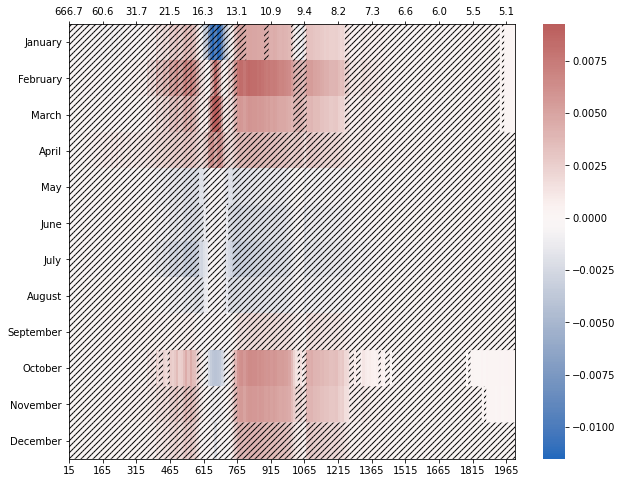

In [82]:
fig_sig,ax_sig = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
ax_sigb = ax_sig.twiny()

statsig_thresh = 95

mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

def tick_function1(X):
    out = ["%.0f" % z for z in X]
    return out

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',ax=ax_sig)#,mask=olr_statsig_spatavg<statsig_thresh)

zm = olr_trend_spatavg.where(olr_statsig_spatavg<statsig_thresh)
x = np.arange(0,olr_trend_spatavg.shape[1]+1)       
y = np.arange(0,olr_trend_spatavg.shape[0]+1)
plt.pcolor(x, y, zm, hatch='////', alpha=0.)

ax_sig.set_xticks(tick_indices)
ax_sig.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
ax_sig.set_yticklabels(mon_dict.values(),fontdict={'fontsize':10,'rotation':0})

ax_sigb.set_xticks(tick_indices)
ax_sigb.set_xbound(ax_sig.get_xbound())
ax_sigb.set_xticklabels(tick_function2(tick_values))

Trends in the stratosphere are large but not significant. This indicates the importance of variability in stratospheric temperatures. When looking for trends by aggregating channels, it's probably best to omit channels sounding the stratosphere.

[Text(0, 1, '666.7'),
 Text(15, 1, '60.6'),
 Text(30, 1, '31.7'),
 Text(45, 1, '21.5'),
 Text(60, 1, '16.3'),
 Text(75, 1, '13.1'),
 Text(90, 1, '10.9'),
 Text(105, 1, '9.4'),
 Text(120, 1, '8.2'),
 Text(135, 1, '7.3'),
 Text(150, 1, '6.6'),
 Text(165, 1, '6.0'),
 Text(180, 1, '5.5'),
 Text(195, 1, '5.1')]

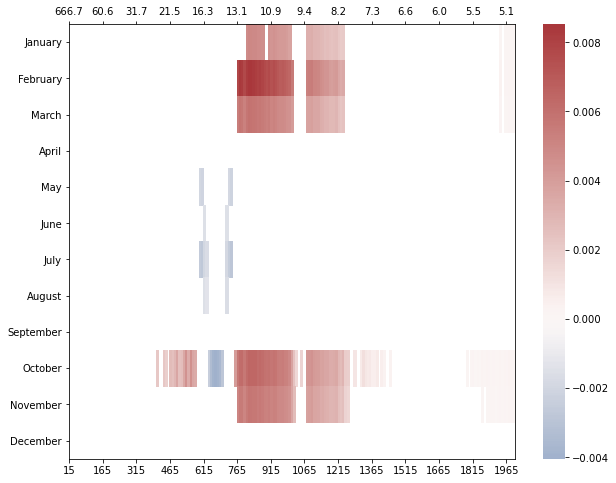

In [85]:
fig_sig,ax_sig = plt.subplots(nrows=1,ncols=1,figsize=(10,8))
ax_sigb = ax_sig.twiny()

statsig_thresh = 95

mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

def tick_function1(X):
    out = ["%.0f" % z for z in X]
    return out

def tick_function2(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

tick_indices = np.where(olr_trend_spatavg.wnum.values % 150 == 15)[0]
tick_values = olr_trend_spatavg.wnum[tick_indices]

im = sns.heatmap(olr_trend_spatavg, center=0, cmap='vlag',ax=ax_sig,mask=olr_statsig_spatavg<statsig_thresh)

zm = olr_trend_spatavg.where(olr_statsig_spatavg<statsig_thresh)
x = np.arange(0,olr_trend_spatavg.shape[1]+1)       
y = np.arange(0,olr_trend_spatavg.shape[0]+1)
# plt.pcolor(x, y, zm, hatch='////', alpha=0.)

ax_sig.set_xticks(tick_indices)
ax_sig.set_xticklabels(tick_function1(tick_values),fontdict={'fontsize':10,'rotation':0})
ax_sig.set_yticklabels(mon_dict.values(),fontdict={'fontsize':10,'rotation':0})

ax_sigb.set_xticks(tick_indices)
ax_sigb.set_xbound(ax_sig.get_xbound())
ax_sigb.set_xticklabels(tick_function2(tick_values))

What are we looking at here?

1. Surface warming in the Fall and Winter coming through the atmospheric window and at ~5um. Note no significant changes in December.  

2. Cooling near the stratosphere/upper troposphere in the summer? It happening at bands off the CO2 absorption peak, so it must be lower in the atmosphere.

### How about the trends we saw in CERES OLR?

In [96]:
olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

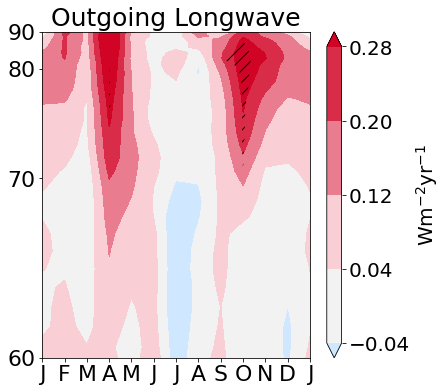

In [99]:
fig_olr,ax_olr = plt.subplots(1,1,figsize=(6,6))

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=5, as_cmap=True)

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
ax_olr.set_ylim(np.sin(np.pi/3),1)
ax_olr.set_yticks(yticks)
ax_olr.set_yticklabels(ytick_labels,fontsize=22)
ax_olr.set_xticks(xticks)
ax_olr.set_xticklabels(xtick_labels,fontsize=22)

lat_weighted1 = np.sin(np.pi/180*olr_trends['lat'])
cmap1 = copy.copy(palette)
im1 = ax_olr.contourf(olr_trends_wrapped['month'],lat_weighted1,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im1.cmap.set_under((0.81,0.91,1.00))
stip = ax_olr.contourf(olr_statsig_wrapped['month'],lat_weighted1,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
ax_olr.set_title('Outgoing Longwave',fontsize=25)
cbar1 = plt.colorbar(im1,ax=ax_olr)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

We see a big increase in outgoing longwave radiation in April. Is this a "real" trend? What is going on?

#### 1. Plot OLR in April spatially for each year in this record. Get a sense of the spatial pattern of OLR.

In [100]:
ceres_olr_spatialsubset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90))

In [112]:
ceres_olr_april = ceres_olr_spatialsubset.sel(time=(ceres_olr_spatialsubset['time.month']==4))
# ceres_olr_april = ceres_olr_spatialsubset[ceres_olr_spatialsubset['time.month']==4]

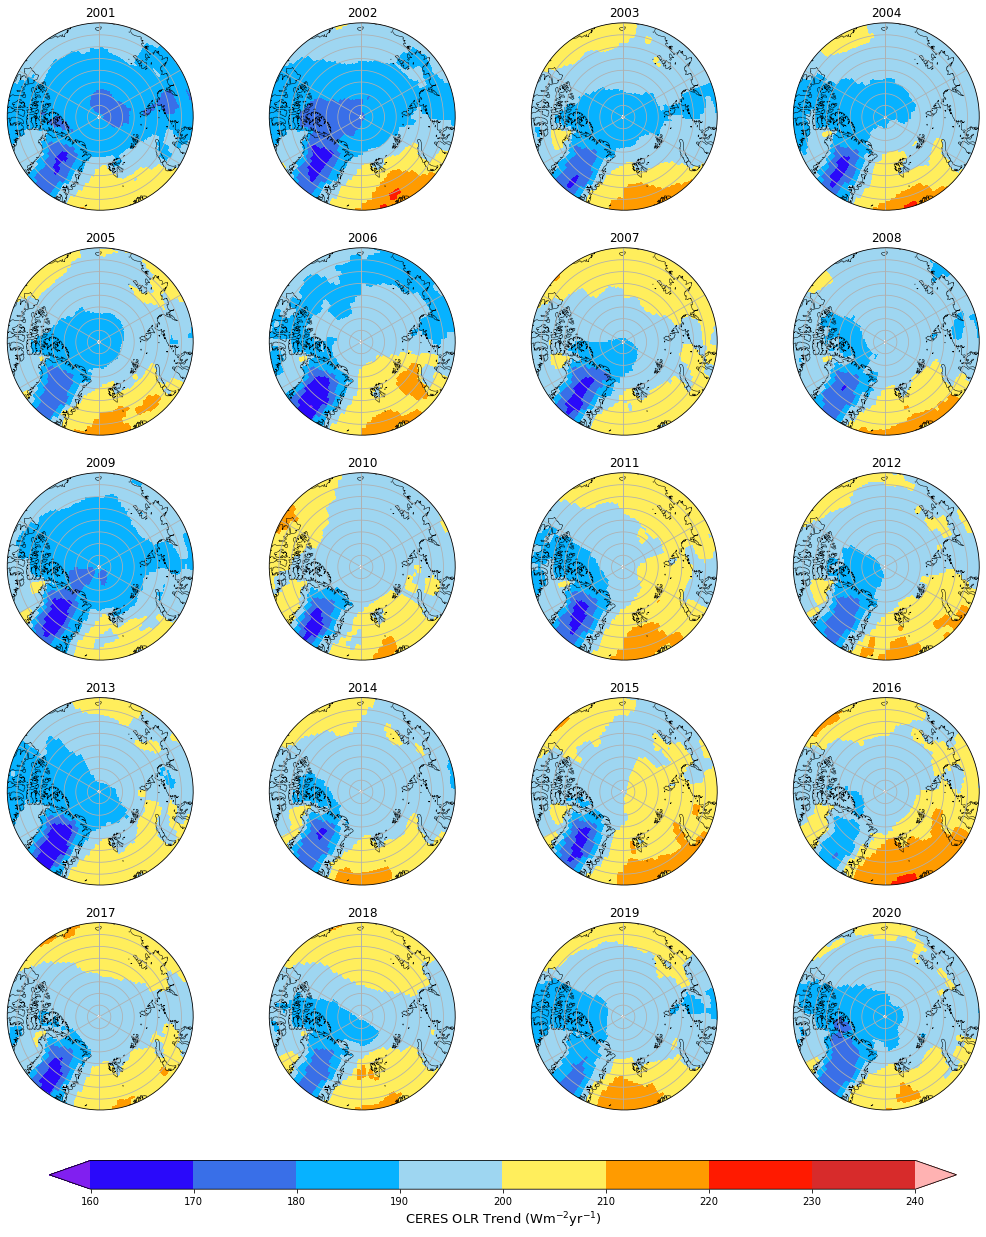

In [122]:
fig,axs = sp_map(nrows=5, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,20])

for i,(ax,month) in enumerate(zip(axs.flat,ceres_olr_april)):
    polarCentral_set_latlim([70,90], ax)
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),
                     cmap=cmaps.ncl_default,levels=np.linspace(160,240,9),extend='both')
    
    add_map_features(ax)
    
    label = month['time.year'].values
    
    ax.set_title(label,fontsize=12)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)

I can see the warming (increased OLR) by looking at these plots, but I can't identify a specific region where the OLR is increasing.

In [128]:
ceres_olr_april_trends,ceres_olr_april_statsig,ceres_olr_april_notnull = compute_trends_n_signif2(ceres_olr_april)

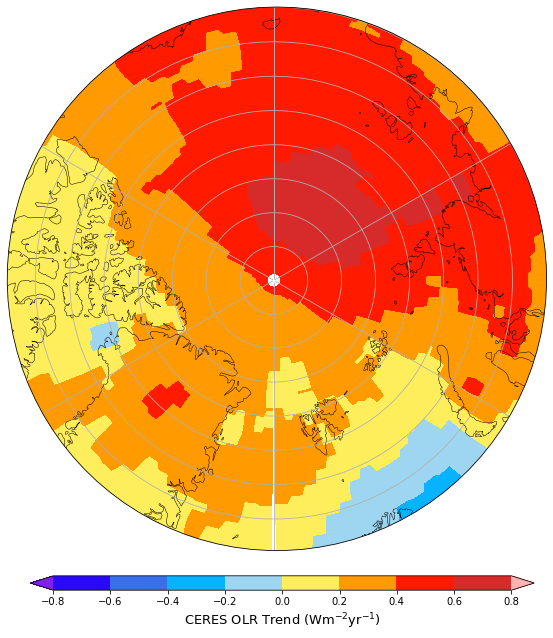

In [159]:
fig,axs = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[10,10])

polarCentral_set_latlim([70,90], axs)
    
im = axs.contourf(ceres_olr_april_trends['lon'],ceres_olr_april_trends['lat'],ceres_olr_april_trends[0,:,:],transform=ccrs.PlateCarree(),
                 cmap=cmaps.ncl_default,extend='both',levels=np.linspace(-0.8,0.8,9))

# axs.fill(a[:,0],a[:,1], hatch='///', edgecolor="gold", alpha=1, fill=False)

# stip = axs.contourf(ceres_olr_april_statsig['lon'],ceres_olr_april_statsig['lat'],ceres_olr_april_statsig[0,:,:], 
#                     colors='none',levels=[0,95,100],hatches=[None,'//'],extend='neither')

# axs.contourf(ceres_olr_april_statsig['lon'],ceres_olr_april_statsig['lat'],ceres_olr_april_statsig[0,:,:], 
#                     colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')

add_map_features(axs)

cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)

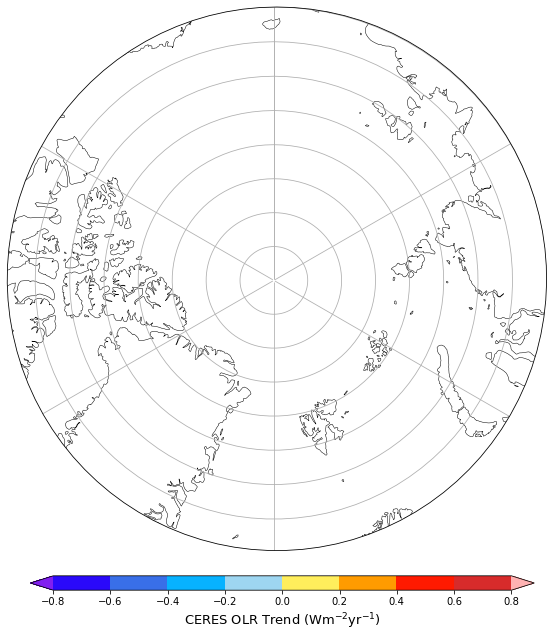

In [160]:
fig,axs = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[10,10])

polarCentral_set_latlim([70,90], axs)
    
# im = axs.contourf(ceres_olr_april_trends['lon'],ceres_olr_april_trends['lat'],ceres_olr_april_trends[0,:,:],transform=ccrs.PlateCarree(),
#                  cmap=cmaps.ncl_default,extend='both',levels=np.linspace(-0.8,0.8,9))

# axs.fill(a[:,0],a[:,1], hatch='///', edgecolor="gold", alpha=1, fill=False)

# stip = axs.contourf(ceres_olr_april_statsig['lon'],ceres_olr_april_statsig['lat'],ceres_olr_april_statsig[0,:,:], 
#                     colors='none',levels=[0,95,100],hatches=[None,'//'],extend='neither')

axs.contourf(ceres_olr_april_statsig['lon'],ceres_olr_april_statsig['lat'],ceres_olr_april_statsig[0,:,:], 
                    colors='none',levels=[0,99,100],hatches=[None,'//'],extend='neither')

add_map_features(axs)

cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)

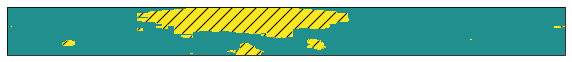

In [158]:
fig,axs = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[10,10])

axs.contourf(ceres_olr_april_statsig['lon'],ceres_olr_april_statsig['lat'],ceres_olr_april_statsig[0,:,:], 
                    levels=[0,99,100],extend='neither',hatches=[None,'//']) # colors='none',

In [ ]:
ax.fill(a[:,0],a[:,1], hatch='///', edgecolor="gold", alpha=1, fill=False)

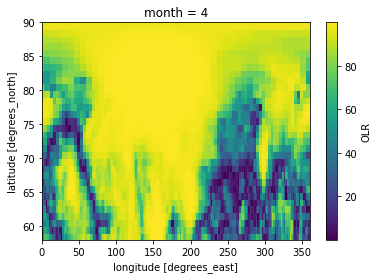

In [141]:
ceres_olr_april_statsig[0,:,:].plot()

#### 2. Look at the individual points making up the trend. Are a few points/end points causing a large portion of the trend?

In [91]:
# Subset data so computations are lighter and significance tests make sense
ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90)).mean('lon')

In [92]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif2(ceres_olr_subset)